In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier, export_text
from sklearn.model_selection import train_test_split
import warnings
import ast
from pandas import json_normalize
from mlxtend.frequent_patterns import apriori, association_rules
from mlxtend.preprocessing import TransactionEncoder



In [2]:
warnings.filterwarnings("ignore")

# Load Excel file
df = pd.read_excel("resolved.xlsx")

# Drop unused columns
drop_cols = ['status', 'summary', 'next_step', 'Comments']
df = df.drop(columns=[col for col in drop_cols if col in df.columns])
df = df.loc[:, ~df.columns.str.contains('^Unnamed')]



In [3]:
# --- Handle recon_sub_status (parse if dictionary-like) ---
def try_parse_dict(val):
    try:
        return ast.literal_eval(val)
    except:
        return None


In [4]:
df

,transaction_id,sys_a_date,sys_a_amount_attribute_1,sys_a_amount_attribute_2,sys_b_date,sys_b_amount_attribute_1,sys_b_amount_attribute_2,txn_type,payment_method,recon_status,recon_sub_status,currency_type
0,67286592,30/07/24,900.000000,1.4,NaN,NaN,NaN,payout,banktransfer,Not Found,"{""amount"":""Not Found-SysB"",""fee"":""Not Found-Sy...",INR
1,15780875,14/08/24,1120.000000,1.4,NaN,NaN,NaN,payout,banktransfer,Not Found,"{""amount"":""Not Found-SysB"",""fee"":""Not Found-Sy...",INR
2,92497763,13/08/24,50.400002,1.4,NaN,NaN,NaN,payout,banktransfer,Not Found,"{""amount"":""Not Found-SysB"",""fee"":""Not Found-Sy...",INR
3,84045829,13/08/24,5.000000,1.4,NaN,NaN,NaN,payout,banktransfer,Not Found,"{""amount"":""Not Found-SysB"",""fee"":""Not Found-Sy...",INR
4,69226073,25/08/24,100.000000,1.4,NaN,NaN,NaN,payout,banktransfer,Not Found,"{""amount"":""Not Found-SysB"",""fee"":""Not Found-Sy...",INR
...,...,...,...,...,...,...,...,...,...,...,...,...
1207,28995144,03/08/24,1330.000000,NaN,03/08/24,1330.0,NaN,forward,NaN,Matched,"{""amount"":""Matched""}",INR
1208,65541442,02/09/24,1490.000000,NaN,02/09/24,1490.0,NaN,forward,NaN,Matched,"{""amount"":""Matched""}",INR
1209,96122116,09/09/24,1063.000000,NaN,09/09/24,1063.0,NaN,forward,NaN,Matched,"{""amount"":""Matched""}",INR
1210,67923478,25/06/24,1673.000000,NaN,25/06/24,1673.0,NaN,forward,NaN,Matched,"{""amount"":""Matched""}",INR


In [5]:

if 'recon_sub_status' in df.columns:
    parsed = df['recon_sub_status'].astype(str).apply(try_parse_dict)
    mask_valid = parsed.apply(lambda x: isinstance(x, dict))
    parsed_dicts = parsed[mask_valid]

    if not parsed_dicts.empty:
        parsed_df = json_normalize(parsed_dicts)
        parsed_df.columns = [f"recon_sub_status_{col}" for col in parsed_df.columns]

        df = df.drop(columns=['recon_sub_status'])
        df = pd.concat([df.reset_index(drop=True), parsed_df.reset_index(drop=True)], axis=1)
    else:
        df['recon_sub_status'] = df['recon_sub_status'].astype(str)



In [6]:
df

,transaction_id,sys_a_date,sys_a_amount_attribute_1,sys_a_amount_attribute_2,sys_b_date,sys_b_amount_attribute_1,sys_b_amount_attribute_2,txn_type,payment_method,recon_status,currency_type,recon_sub_status_amount,recon_sub_status_fee
0,67286592,30/07/24,900.000000,1.4,NaN,NaN,NaN,payout,banktransfer,Not Found,INR,Not Found-SysB,Not Found-SysB
1,15780875,14/08/24,1120.000000,1.4,NaN,NaN,NaN,payout,banktransfer,Not Found,INR,Not Found-SysB,Not Found-SysB
2,92497763,13/08/24,50.400002,1.4,NaN,NaN,NaN,payout,banktransfer,Not Found,INR,Not Found-SysB,Not Found-SysB
3,84045829,13/08/24,5.000000,1.4,NaN,NaN,NaN,payout,banktransfer,Not Found,INR,Not Found-SysB,Not Found-SysB
4,69226073,25/08/24,100.000000,1.4,NaN,NaN,NaN,payout,banktransfer,Not Found,INR,Not Found-SysB,Not Found-SysB
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1207,28995144,03/08/24,1330.000000,NaN,03/08/24,1330.0,NaN,forward,NaN,Matched,INR,Matched,NaN
1208,65541442,02/09/24,1490.000000,NaN,02/09/24,1490.0,NaN,forward,NaN,Matched,INR,Matched,NaN
1209,96122116,09/09/24,1063.000000,NaN,09/09/24,1063.0,NaN,forward,NaN,Matched,INR,Matched,NaN
1210,67923478,25/06/24,1673.000000,NaN,25/06/24,1673.0,NaN,forward,NaN,Matched,INR,Matched,NaN


In [7]:
# --- Convert date columns to numeric features ---
date_cols = ['sys_a_date', 'sys_b_date']
for col in date_cols:
    if col in df.columns:
        df[col] = pd.to_datetime(df[col], errors='coerce')
        df[f'{col}_day'] = df[col].dt.day
        df[f'{col}_month'] = df[col].dt.month
        df[f'{col}_year'] = df[col].dt.year
        df = df.drop(columns=col)



In [8]:
# --- Fill missing numeric values with -1 ---
df = df.fillna(-1)

# --- Encode categorical columns ---
cat_cols = df.select_dtypes(include='object').columns
label_encoders = {}
for col in cat_cols:
    df[col] = df[col].astype(str)
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

# Add target column (1 for resolved)
df['resolved'] = 1

# Separate features and target
X = df.drop(columns=['transaction_id', 'resolved'], errors='ignore')
y = df['resolved']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Decision Tree
clf = DecisionTreeClassifier(max_depth=5, random_state=42)
clf.fit(X_train, y_train)

# Show learned rules
print("\n=== Decision Tree Rules (Pattern for Resolved Cases) ===\n")
print(export_text(clf, feature_names=list(X.columns)))



=== Decision Tree Rules (Pattern for Resolved Cases) ===

|--- class: 0



In [9]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import ast
from pandas import json_normalize
import matplotlib.pyplot as plt
import warnings


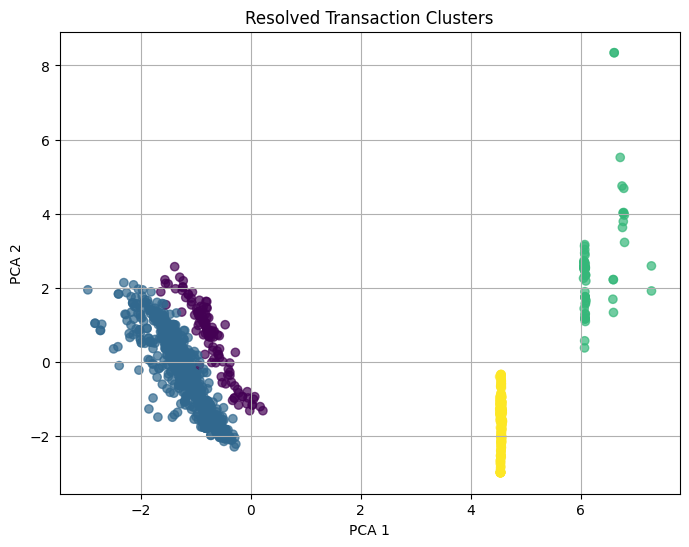


=== Cluster Pattern Summary ===
         transaction_id  sys_a_amount_attribute_1  sys_a_amount_attribute_2  \
cluster                                                                       
0          5.252675e+07               1623.318584                 -1.000000   
1          5.535381e+07               1625.679354                 -1.000000   
2          5.852247e+07               3114.058471                  1.745882   
3          5.775780e+07                185.244898                 -1.000000   

         sys_b_amount_attribute_1  sys_b_amount_attribute_2  txn_type  \
cluster                                                                 
0                     1623.318584                      -1.0       3.0   
1                     1625.679354                      -1.0       0.0   
2                       -1.000000                      -1.0       2.0   
3                       -1.000000                      -1.0       1.0   

         payment_method  recon_status  currency_type 

In [10]:
# Encode categoricals
cat_cols = df.select_dtypes(include='object').columns
for col in cat_cols:
    df[col] = df[col].astype(str)
    df[col] = LabelEncoder().fit_transform(df[col])

# Fill missing values
df = df.fillna(-1)

# Normalize for clustering
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df.drop(columns=['transaction_id'], errors='ignore'))

# K-Means clustering
kmeans = KMeans(n_clusters=4, random_state=42)
df['cluster'] = kmeans.fit_predict(X_scaled)

# Reduce dimensions for visualization
pca = PCA(n_components=2)
pca_result = pca.fit_transform(X_scaled)
df['pca1'] = pca_result[:, 0]
df['pca2'] = pca_result[:, 1]

# Visualize clusters
plt.figure(figsize=(8, 6))
plt.scatter(df['pca1'], df['pca2'], c=df['cluster'], cmap='viridis', alpha=0.7)
plt.title('Resolved Transaction Clusters')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.grid(True)
plt.show()

# Analyze cluster centroids
cluster_summary = df.groupby('cluster').mean(numeric_only=True)
print("\n=== Cluster Pattern Summary ===")
print(cluster_summary)

In [12]:
drop_cols = [
    'transaction_id', 'sys_a_date', 'sys_b_date',
    'status', 'summary', 'next_step', 'Comments'
]
df = df.drop(columns=[col for col in drop_cols if col in df.columns], errors='ignore')

# Flatten recon_sub_status if dictionary-like
# Keep only object (categorical) columns
df = df.select_dtypes(include='object')

# Fill nulls and encode rows as sets of key=value
df = df.fillna("NA").astype(str)


In [18]:
transactions = df.apply(lambda row: [f"{col}={val}" for col, val in row.items()], axis=1).tolist()

# Limit data for memory safety (optional: reduce to 10k rows)
transactions = transactions[:10000]

# Encode


In [19]:
te = TransactionEncoder()
te_ary = te.fit(transactions).transform(transactions)
df_encoded = pd.DataFrame(te_ary, columns=te.columns_)

# Run Apriori with slightly higher min_support to reduce memory
frequent_itemsets = apriori(df_encoded, min_support=0.1, use_colnames=True)

# Get rules
rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.8)

# Show top rules
print("\n=== Light Frequent Patterns ===")
print(rules[['antecedents', 'consequents', 'support', 'confidence', 'lift']].sort_values(by='lift', ascending=False).head(10))


=== Light Frequent Patterns ===
                                           antecedents  \
980                                   (txn_type=payin)   
977               (txn_type=payin, payment_method=upi)   
975  (recon_sub_status_amount=Not Found-SysB, txn_t...   
974  (recon_sub_status_fee=NA, recon_status=Not Found)   
973      (recon_sub_status_fee=NA, payment_method=upi)   
971  (recon_sub_status_fee=NA, recon_sub_status_amo...   
969                (currency_type=INR, txn_type=payin)   
968  (recon_status=Not Found, txn_type=payin, payme...   
966  (recon_sub_status_amount=Not Found-SysB, txn_t...   
965  (recon_sub_status_amount=Not Found-SysB, txn_t...   

                                           consequents   support  confidence  \
980  (currency_type=INR, recon_sub_status_fee=NA, r...  0.121287         1.0   
977  (currency_type=INR, recon_sub_status_fee=NA, r...  0.121287         1.0   
975  (currency_type=INR, recon_sub_status_fee=NA, r...  0.121287         1.0   
974  (cu

### 📊 Columns Explained

| Term        | Meaning                                                                                         | Example                                                                 |
|-------------|--------------------------------------------------------------------------------------------------|-------------------------------------------------------------------------|
| Antecedents | The condition or "if" part                                                                      | `txn_type=CREDIT` AND `recon_sub_status_code=MATCHED`                  |
| Consequents | The result or "then" part                                                                       | `currency_type=INR`                                                    |
| Support     | How often the whole rule (antecedents + consequents) appears in the data (as a fraction)        | 0.32 → rule appears in 32% of transactions                             |
| Confidence  | How often the consequents are true *when* the antecedents are true                              | 0.85 → in 85% of cases where `txn_type=CREDIT` and status is MATCHED   |
| Lift        | How much more likely the consequents are given the antecedents, compared to random chance       | 1.2 → the rule is 20% better than random chance                        |


In [20]:
rules

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski
0,(currency_type=INR),(payment_method=NA),1.000000,0.808581,0.808581,0.808581,1.000000,1.0,0.000000,1.000000,0.0,0.808581,0.000000,0.904290
1,(payment_method=NA),(currency_type=INR),0.808581,1.000000,0.808581,1.000000,1.000000,1.0,0.000000,inf,0.0,0.808581,0.000000,0.904290
2,(payment_method=upi),(currency_type=INR),0.126238,1.000000,0.126238,1.000000,1.000000,1.0,0.000000,inf,0.0,0.126238,0.000000,0.563119
3,(currency_type=INR),(recon_status=Matched),1.000000,0.808581,0.808581,0.808581,1.000000,1.0,0.000000,1.000000,0.0,0.808581,0.000000,0.904290
4,(recon_status=Matched),(currency_type=INR),0.808581,1.000000,0.808581,1.000000,1.000000,1.0,0.000000,inf,0.0,0.808581,0.000000,0.904290
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
977,"(txn_type=payin, payment_method=upi)","(currency_type=INR, recon_sub_status_fee=NA, r...",0.121287,0.121287,0.121287,1.000000,8.244898,1.0,0.106577,inf,1.0,1.000000,1.000000,1.000000
978,"(recon_status=Not Found, txn_type=payin)","(currency_type=INR, recon_sub_status_fee=NA, r...",0.121287,0.121287,0.121287,1.000000,8.244898,1.0,0.106577,inf,1.0,1.000000,1.000000,1.000000
979,"(recon_status=Not Found, payment_method=upi)","(currency_type=INR, recon_sub_status_fee=NA, r...",0.126238,0.121287,0.121287,0.960784,7.921569,1.0,0.105976,22.407178,1.0,0.960784,0.955371,0.980392
980,(txn_type=payin),"(currency_type=INR, recon_sub_status_fee=NA, r...",0.121287,0.121287,0.121287,1.000000,8.244898,1.0,0.106577,inf,1.0,1.000000,1.000000,1.000000


In [21]:
rules_cleaned = rules[["antecedents", "consequents"]]
rules_cleaned

,antecedents,consequents
0,(currency_type=INR),(payment_method=NA)
1,(payment_method=NA),(currency_type=INR)
2,(payment_method=upi),(currency_type=INR)
3,(currency_type=INR),(recon_status=Matched)
4,(recon_status=Matched),(currency_type=INR)
...,...,...
977,"(txn_type=payin, payment_method=upi)","(currency_type=INR, recon_sub_status_fee=NA, r..."
978,"(recon_status=Not Found, txn_type=payin)","(currency_type=INR, recon_sub_status_fee=NA, r..."
979,"(recon_status=Not Found, payment_method=upi)","(currency_type=INR, recon_sub_status_fee=NA, r..."
980,(txn_type=payin),"(currency_type=INR, recon_sub_status_fee=NA, r..."


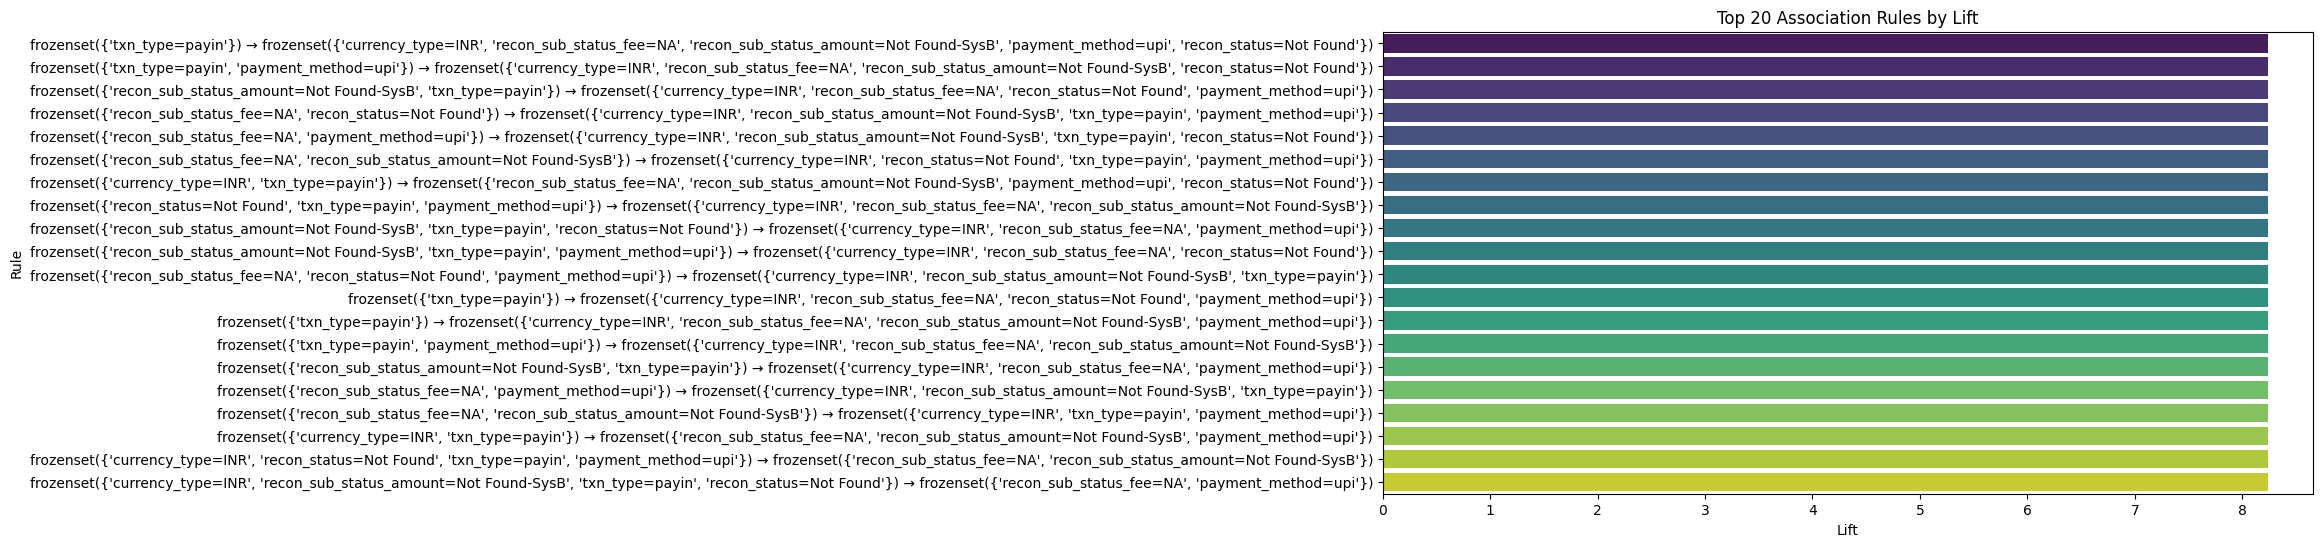

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns

# Top N rules
top_n = 20
rules['rule'] = rules['antecedents'].astype(str) + " → " + rules['consequents'].astype(str)
top_rules = rules.sort_values(by='lift', ascending=False).head(top_n)

# Bar plot
plt.figure(figsize=(12, 6))
sns.barplot(y=top_rules['rule'], x=top_rules['lift'], palette='viridis')
plt.xlabel("Lift")
plt.ylabel("Rule")
plt.title(f"Top {top_n} Association Rules by Lift")
plt.tight_layout()
plt.show()

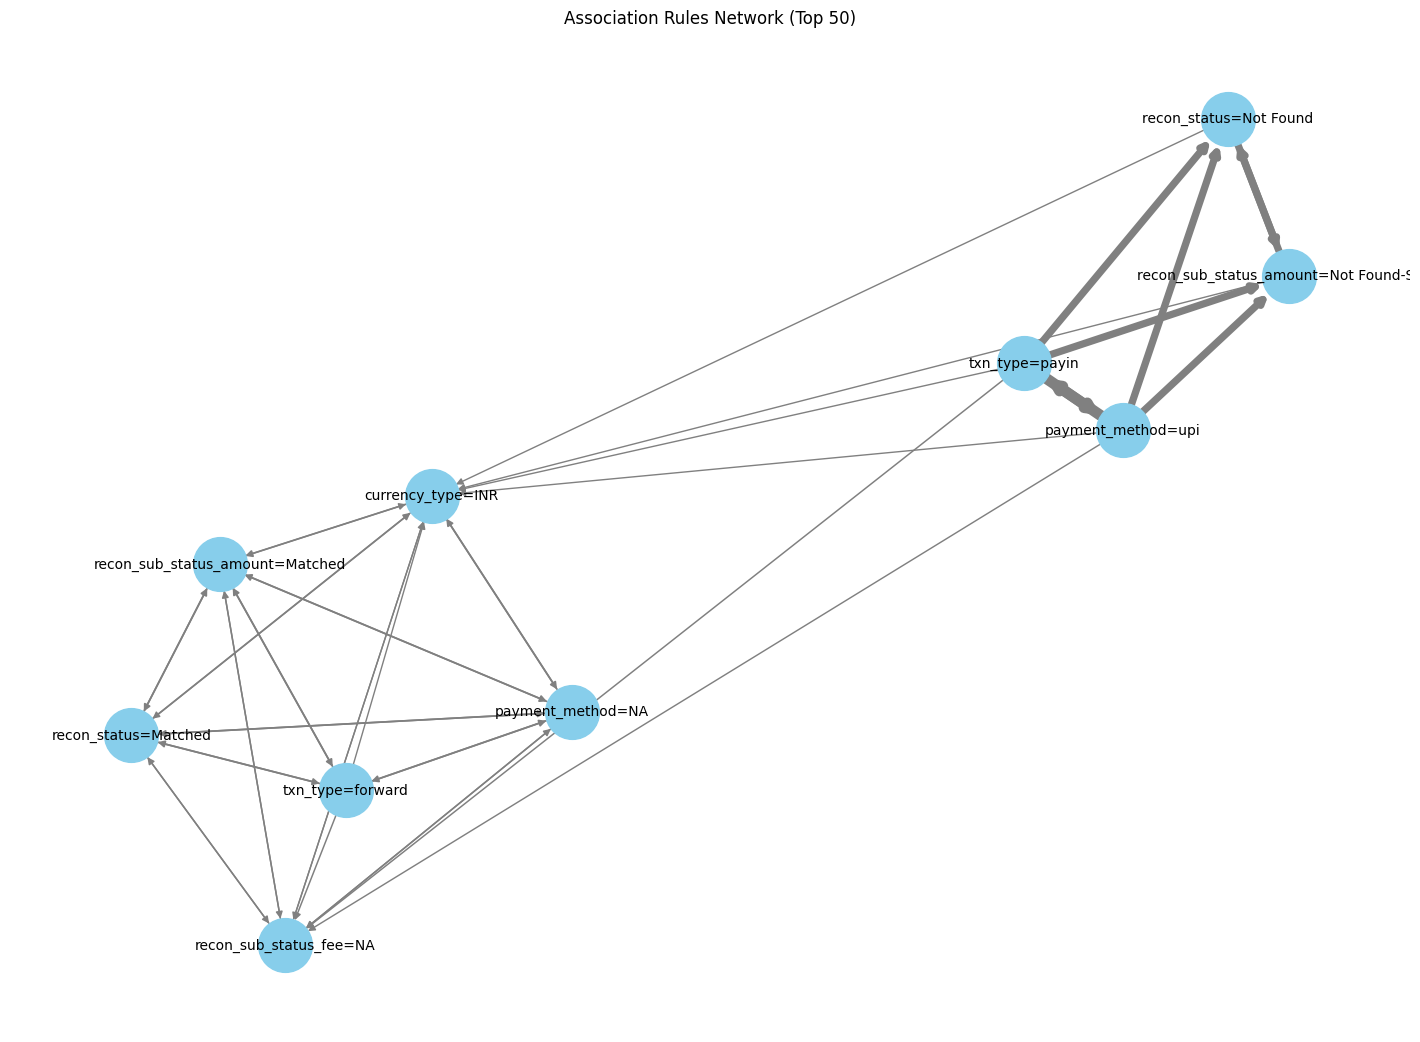

In [23]:
import networkx as nx
import matplotlib.pyplot as plt

# Create graph
G = nx.DiGraph()

for idx, row in rules.head(50).iterrows():
    for a in row['antecedents']:
        for c in row['consequents']:
            G.add_edge(a, c, weight=row['lift'])

plt.figure(figsize=(14, 10))
pos = nx.spring_layout(G, k=0.5, seed=42)
edges = G.edges(data=True)
weights = [d['weight'] for (_, _, d) in edges]

nx.draw(G, pos, with_labels=True, node_color='skyblue', edge_color='gray',
        node_size=1500, font_size=10, width=weights, arrows=True)
plt.title("Association Rules Network (Top 50)")
plt.show()


In [25]:
import pandas as pd

# Assuming `rules` is your DataFrame from association_rules
# Prepare readable text for each rule
rules['Readable Rule'] = rules.apply(
    lambda row: f"IF {' AND '.join(row['antecedents'])} THEN {' AND '.join(row['consequents'])} "
                f"({row['confidence'] * 100:.1f}% confidence, lift: {row['lift']:.2f})",
    axis=1
)

# Reorder & select useful columns
export_df = rules[['Readable Rule', 'support', 'confidence', 'lift']].copy()
export_df = export_df.sort_values(by='lift', ascending=False)

# Save to Excel
export_df.to_excel("resolved_rule_patterns.xlsx", index=False)

In [26]:
export_df

,Readable Rule,support,confidence,lift
980,IF txn_type=payin THEN currency_type=INR AND r...,0.121287,1.000000,8.244898
977,IF txn_type=payin AND payment_method=upi THEN ...,0.121287,1.000000,8.244898
975,IF recon_sub_status_amount=Not Found-SysB AND ...,0.121287,1.000000,8.244898
974,IF recon_sub_status_fee=NA AND recon_status=No...,0.121287,1.000000,8.244898
973,IF recon_sub_status_fee=NA AND payment_method=...,0.121287,1.000000,8.244898
...,...,...,...,...
62,IF txn_type=forward AND payment_method=NA THEN...,0.715347,1.000000,1.000000
50,IF recon_sub_status_amount=Matched AND payment...,0.808581,1.000000,1.000000
2,IF payment_method=upi THEN currency_type=INR (...,0.126238,1.000000,1.000000
1,IF payment_method=NA THEN currency_type=INR (1...,0.808581,1.000000,1.000000
